In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a one millsecond trajectory of ubiquitin generated from DEShaw Research:

https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b02024

Trajectory from DESRES can be downloaded here:
https://www.dropbox.com/s/qk4winh3y66bynm/ubq.desres.s500.zip?dl=0

It can be compared to an NMR ensmeble:
https://www.wwpdb.org/pdb?id=pdb_00002kox

In [5]:
pdb='./Ubiquitin/ubq.pdb'
trajectory='./Ubiquitin/ubq.desres.s500.dcd'
outdir='./Ubiquitin/output'

if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: ./Ubiquitin/output
pdb: ./Ubiquitin/ubq.pdb
trjaectory: ./Ubiquitin/ubq.desres.s500.dcd


In [6]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [7]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 10088

Starting frame: 0

Last frame: 10088

sequence:  [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names:  ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'AL

In [8]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id
#residue_num

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

In [9]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

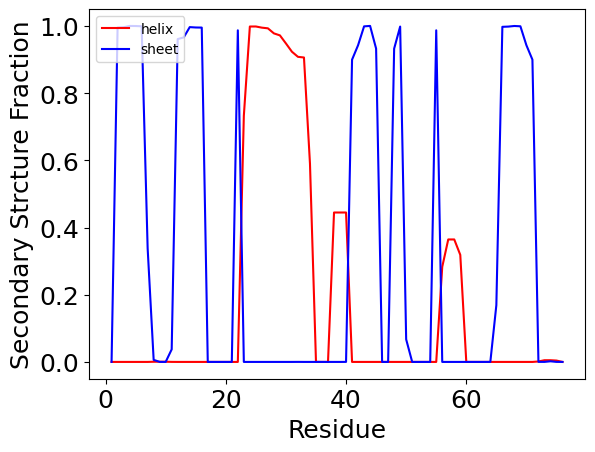

In [10]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


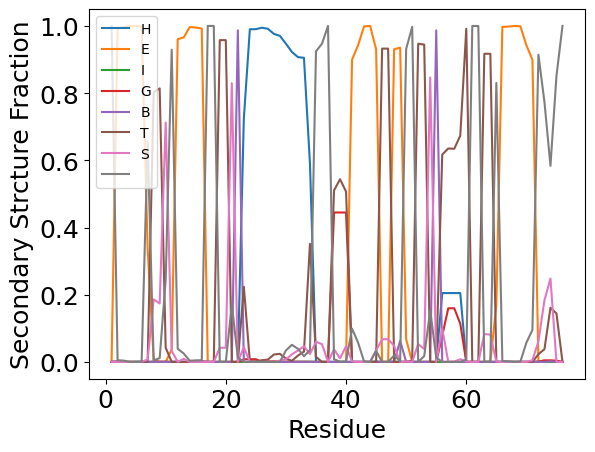

In [14]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [15]:
#Find all the frames where a given residue is H or E
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

40
Residue 40
helix frames: 4486 [    2     3     4 ... 10085 10086 10087]
beta frames: 1 [4609]


In [16]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [17]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices = indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [18]:
sequence

' [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]'

In [19]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




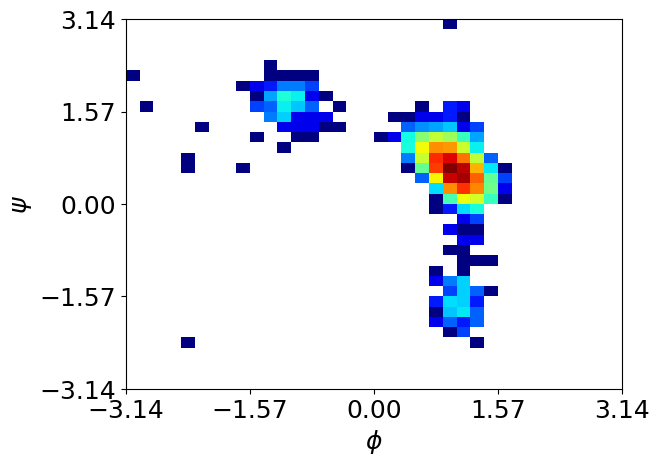

In [20]:
plot_phipsi(46)

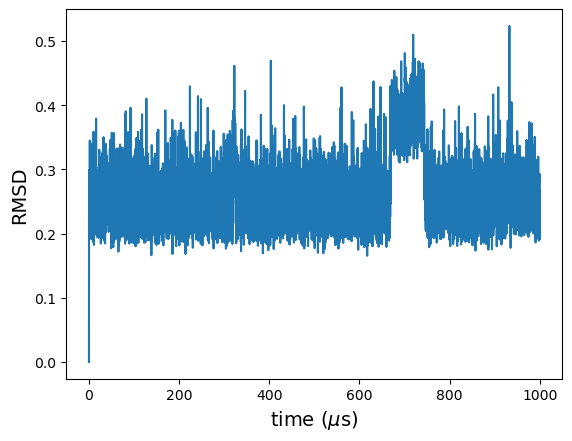

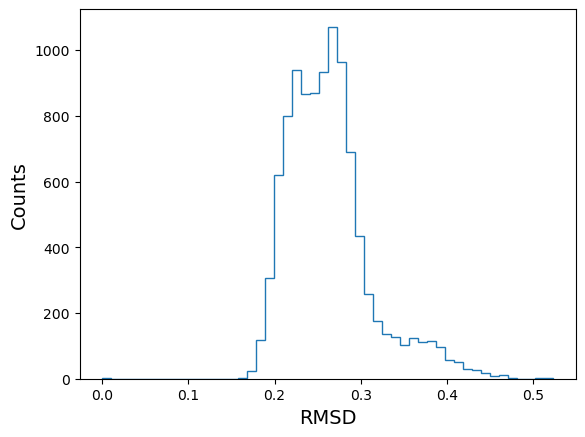

In [23]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

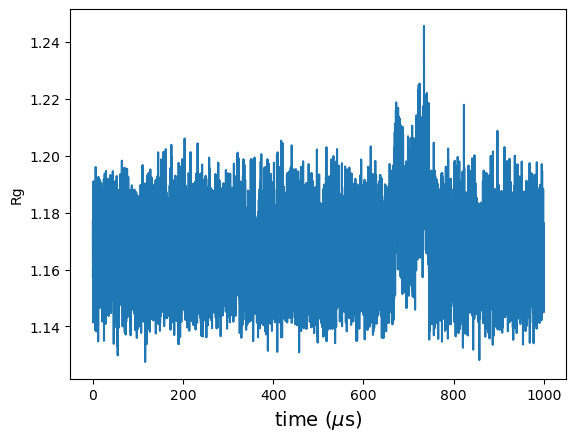

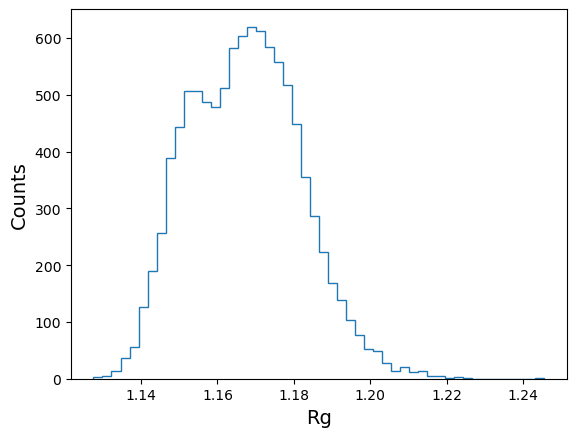

In [24]:
#Lets calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [25]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
    

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
THR22-N -- ASN25-OD1
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N -- LYS27-O
ASP32-N

In [26]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   1 285] MET1-N VAL17-O
[  0   2 285] MET1-N VAL17-O
[  0   3 285] MET1-N VAL17-O
[ 36  37 254] ILE3-N LEU15-O
[  55   56 1044] PHE4-N SER65-O
[ 75  76 221] VAL5-N ILE13-O
[  91   92 1077] LYS6-N LEU67-O
[113 114 188] THR7-N LYS11-O
[127 128 119] LEU8-N THR7-OG1
[ 127  128 1113] LEU8-N LEU69-O
[146 147 119] THR9-N THR7-OG1
[160 161 126] GLY10-N THR7-O
[167 168 119] LYS11-N THR7-OG1
[183 184 551] LYS11-NZ GLU34-OE1
[183 184 552] LYS11-NZ GLU34-OE2
[183 185 551] LYS11-NZ GLU34-OE1
[183 185 552] LYS11-NZ GLU34-OE2
[183 186 551] LYS11-NZ GLU34-OE1
[183 186 552] LYS11-NZ GLU34-OE2
[203 204  90] ILE13-N VAL5-O
[236 237  54] LEU15-N ILE3-O
[270 271  18] VAL17-N MET1-O
[286 287 334] GLU18-N ASP21-OD1
[286 287 335] GLU18-N ASP21-OD2
[326 327 300] ASP21-N GLU18-O
[338 339 394] THR22-N ASN25-OD1
[352 353 869] ILE23-N ARG54-O
[371 372 838] GLU24-N ASP52-O
[386 387 344] ASN25-N THR22-OG1
[386 387 351] ASN25-N THR22-O
[395 396 344] ASN25-ND2 THR22-OG1
[395 397 344] ASN25-ND2 THR22-OG1
[400 401 

[  55   56 1044] PHE4-N SER65-O


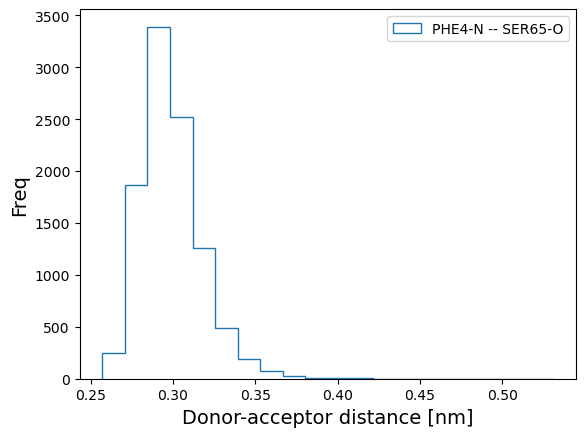

In [27]:
Hbond_index=4
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

***We're going to run a Principle Component Analysis (PCA)***

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [28]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(10088, 2)


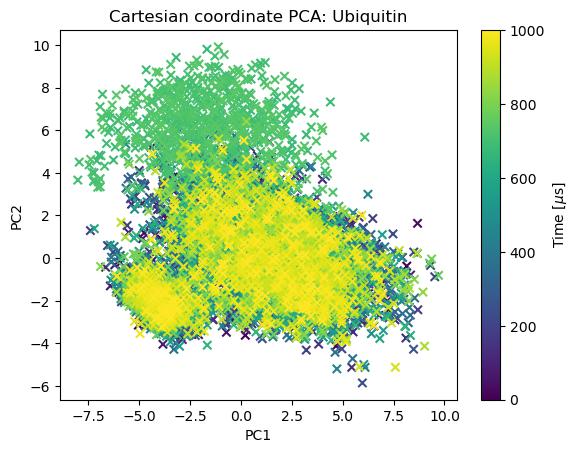

In [29]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')

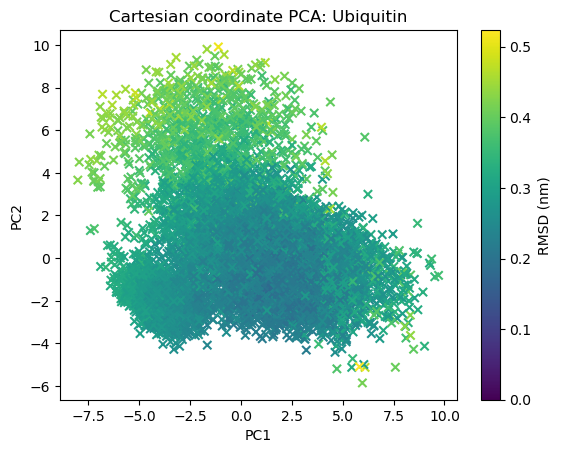

In [30]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

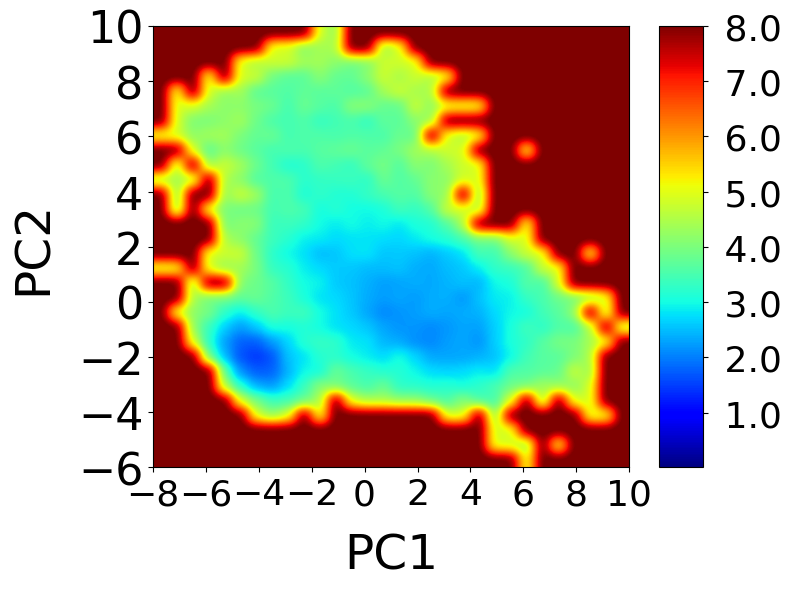

In [31]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

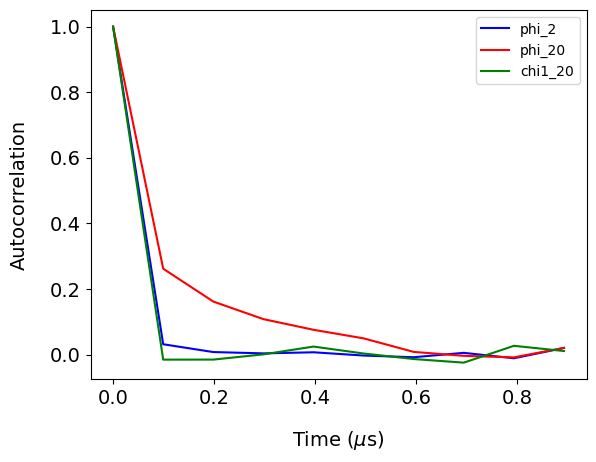

In [40]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][20],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][20],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

In [ ]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 76):
    contact_map = []
    contact_distance = []
    for j in range(1, 76):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [ ]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas:

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)


9) Visualize the most populated clusters from your clustering analysis

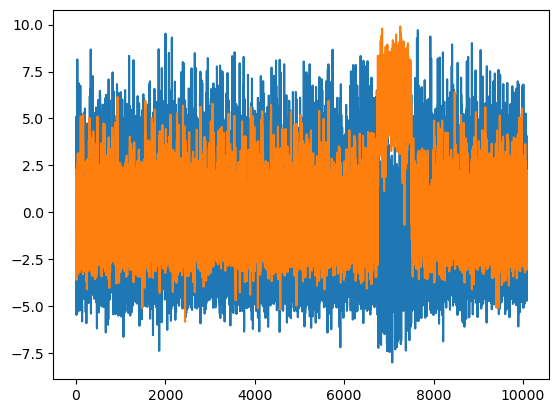

In [43]:
##1.) Determine what is structural different about the "minor state" populated between 650-750us. Can you make a visualization of the two states?
plt.plot(PC1)
plt.plot(PC2)

In [44]:
major_state = np.where((PC2 < 1.75) & (PC2 > -1.75))[0] 
minor_state = np.where((PC2 < 10) & (PC2 > 5.5))[0] 
major_state_reduced = major_state[::15]

In [45]:
print(major_state_reduced)

[    0    23    44    64    92   115   136   161   182   214   244   267
   291   316   348   380   405   433   459   479   505   529   549   577
   603   628   650   670   698   723   751   780   801   820   843   866
   890   923   948   970  1003  1031  1055  1073  1091  1112  1132  1160
  1183  1211  1237  1260  1283  1311  1331  1357  1387  1408  1435  1458
  1478  1506  1524  1556  1576  1601  1639  1658  1686  1707  1734  1760
  1791  1810  1828  1854  1877  1901  1941  1962  1990  2012  2037  2059
  2085  2107  2134  2163  2183  2203  2222  2257  2282  2307  2330  2352
  2379  2416  2442  2469  2501  2530  2554  2580  2607  2638  2668  2686
  2707  2726  2753  2779  2800  2825  2846  2872  2897  2926  2944  2968
  2993  3018  3046  3068  3093  3113  3139  3162  3193  3214  3250  3276
  3301  3327  3350  3377  3400  3426  3452  3475  3500  3524  3551  3579
  3601  3623  3651  3682  3717  3739  3760  3792  3817  3842  3869  3912
  3935  3962  3982  4002  4028  4050  4082  4105  4

In [46]:
print(minor_state)

[ 931 1551 2392 2785 3053 3059 3909 4363 5649 6744 6746 6749 6750 6753
 6755 6756 6757 6759 6764 6765 6766 6767 6768 6769 6773 6776 6777 6778
 6779 6780 6782 6783 6784 6785 6786 6787 6788 6792 6793 6794 6796 6799
 6800 6803 6804 6810 6813 6816 6817 6818 6821 6822 6827 6828 6829 6830
 6831 6832 6833 6834 6836 6840 6841 6843 6844 6846 6847 6848 6849 6850
 6852 6855 6857 6858 6859 6863 6865 6866 6867 6868 6869 6870 6873 6874
 6877 6878 6880 6884 6885 6886 6887 6889 6896 6897 6900 6901 6903 6904
 6905 6906 6907 6909 6912 6913 6914 6916 6923 6924 6926 6927 6928 6929
 6933 6934 6935 6936 6937 6938 6939 6940 6941 6942 6944 6945 6947 6948
 6950 6952 6953 6954 6957 6959 6960 6961 6964 6965 6966 6969 6970 6971
 6973 6974 6975 6977 6979 6981 6982 6984 6985 6988 6990 6991 6992 6993
 6994 6995 6996 6997 7000 7001 7002 7003 7004 7006 7007 7008 7010 7011
 7013 7014 7015 7018 7019 7020 7021 7022 7023 7024 7025 7026 7027 7029
 7031 7032 7033 7034 7035 7037 7038 7039 7040 7041 7044 7046 7047 7048
 7049 

#Q1
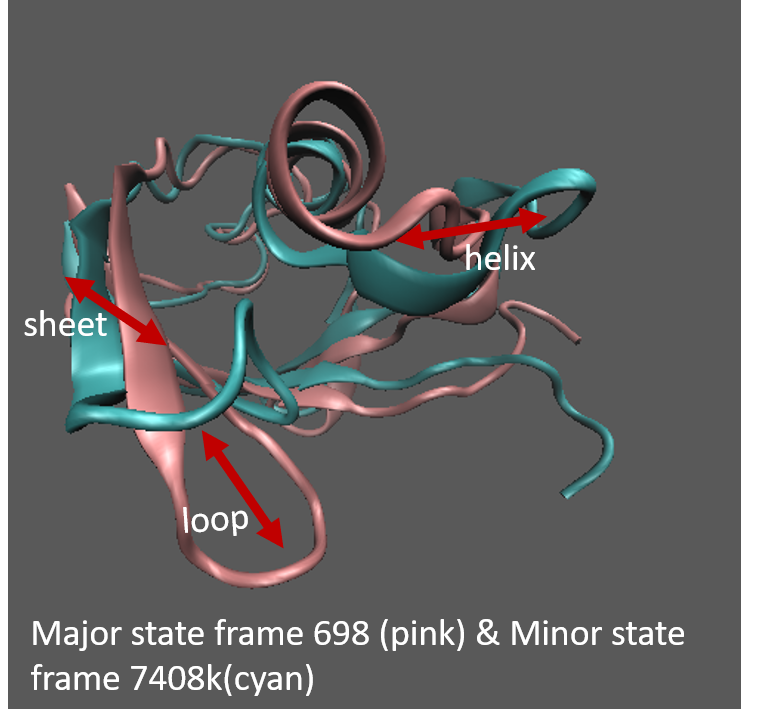

#Q1
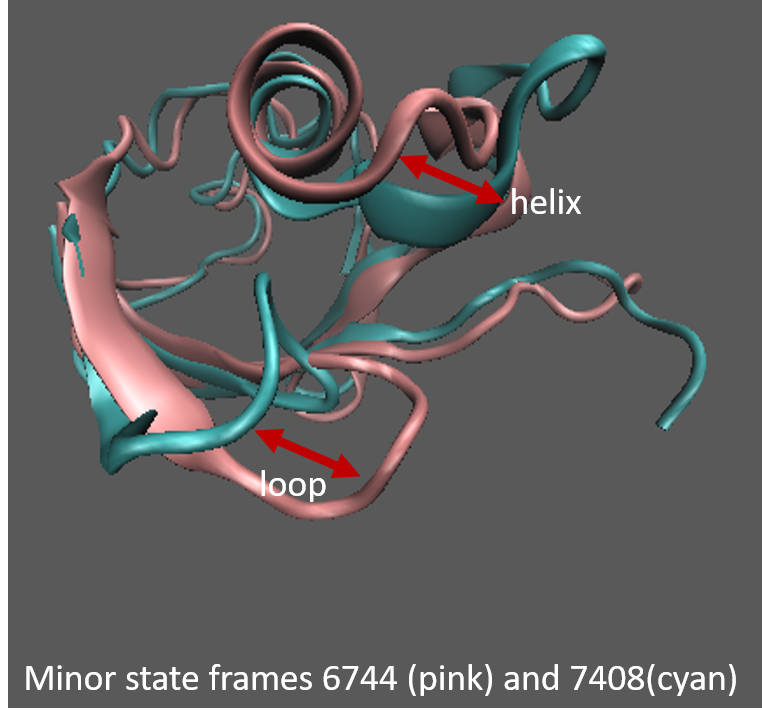

Here is the equation used to calculate circular correlation coefficients for dihedral angles

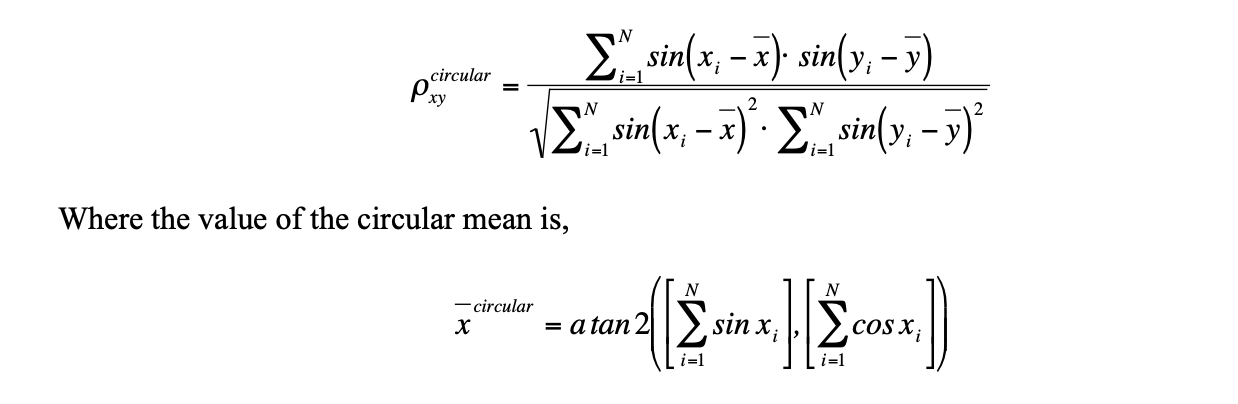


Lets calculate some correlations between dihedrals found in the paper: 


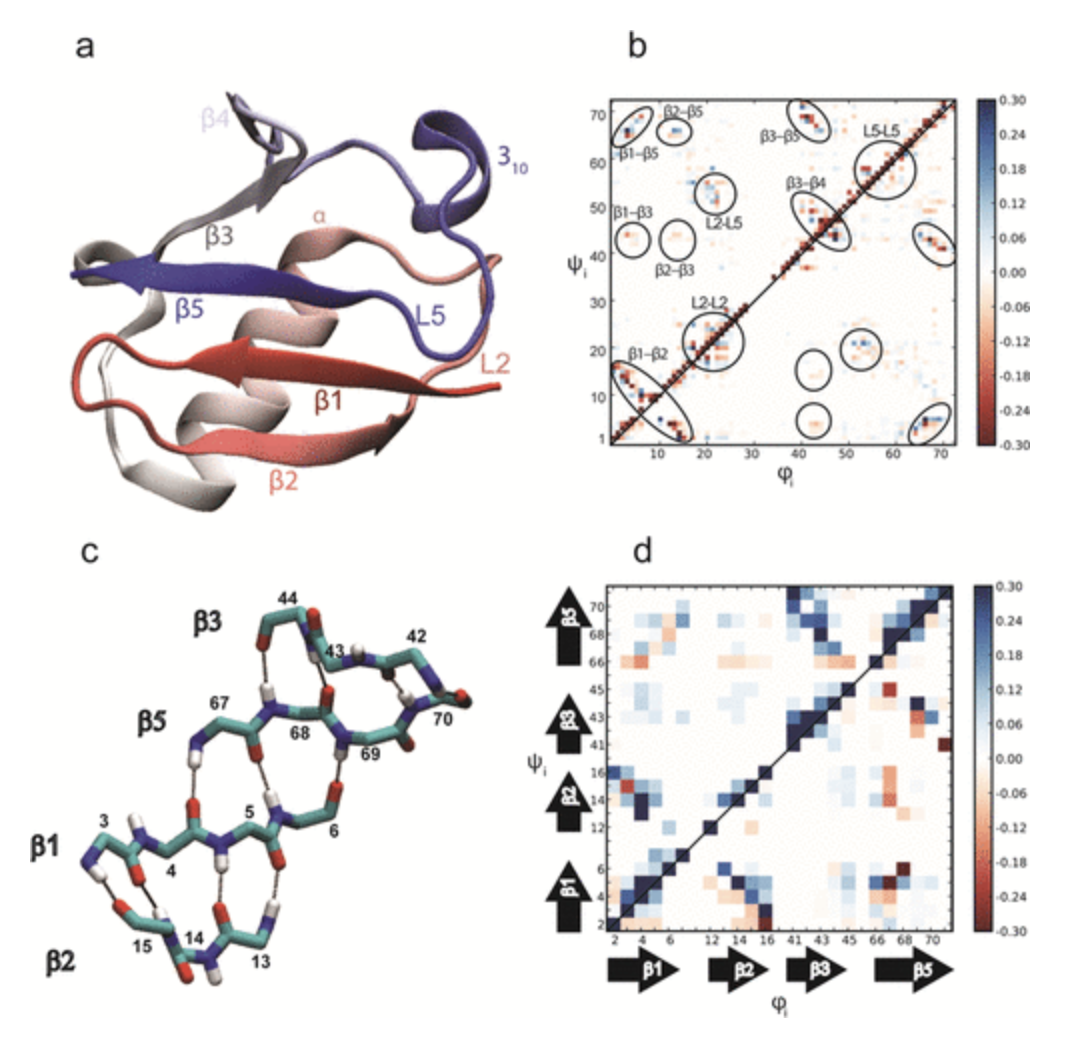

In [47]:
np.argmax(rg)

7408

Lags represent the time intervals over which the autocorrelation is calculated (range here is 0 -9).
#[2] eg is the index 2 of the phi angle which is same as the 3rd phi dihedral angle
To identify dihedral angles that have very long correlation times using autocorrelation analysis, you can examine the decay of the autocorrelation function. Dihedral angles with slower decay in autocorrelation likely have longer correlation times.

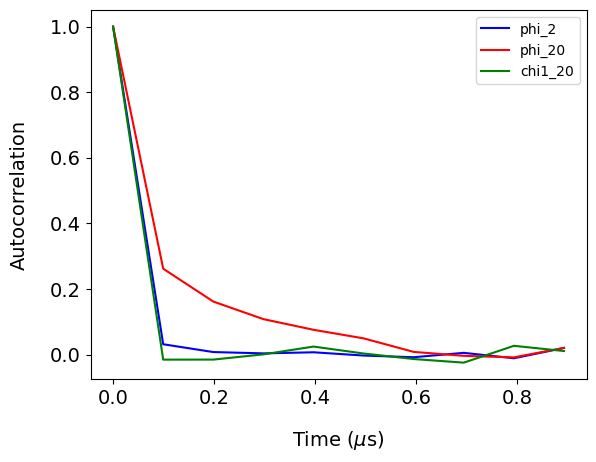

In [48]:
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Define time in microseconds
time = np.linspace(0, 1000, trj.n_frames)

# Define the lags for autocorrelation analysis
lags = range(10)

# Calculate autocorrelation for specific dihedral angles
phi2_acf = autocorr1(dihedral_dict['phi'][2], lags)
phi20_acf = autocorr1(dihedral_dict['phi'][20], lags)
chi20_acf = autocorr1(dihedral_dict['chi1'][20], lags)

# Plot autocorrelation functions
plt.plot(time[lags], phi2_acf, color='b', label='phi_2')
plt.plot(time[lags], phi20_acf, color='r', label='phi_20')
plt.plot(time[lags], chi20_acf, color='g', label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()


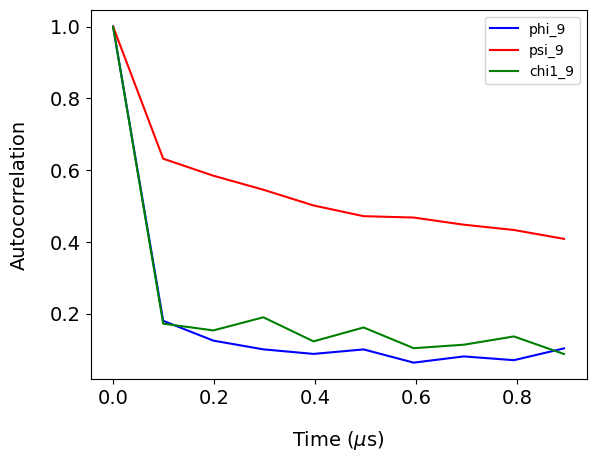

In [79]:
###### 2.) Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi9_acf=autocorr1(dihedral_dict['phi'][9],lags) #acf = autocorrelation fun
psi9_acf=autocorr1(dihedral_dict['psi'][9],lags)
chi9_acf=autocorr1(dihedral_dict['chi1'][9],lags)

plt.plot(time[lags],phi9_acf,color='b',label='phi_9')
plt.plot(time[lags],psi9_acf,color='r',label='psi_9')
plt.plot(time[lags],chi9_acf,color='g',label='chi1_9')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

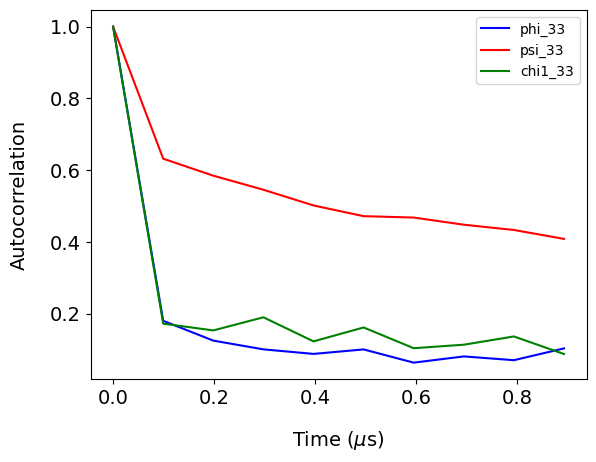

In [88]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi33_acf=autocorr1(dihedral_dict['phi'][9],lags) #acf = autocorrelation fun
psi33_acf=autocorr1(dihedral_dict['psi'][9],lags)
chi33_acf=autocorr1(dihedral_dict['chi1'][9],lags)

plt.plot(time[lags],phi33_acf,color='b',label='phi_33')
plt.plot(time[lags],psi33_acf,color='r',label='psi_33')
plt.plot(time[lags],chi33_acf,color='g',label='chi1_33')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

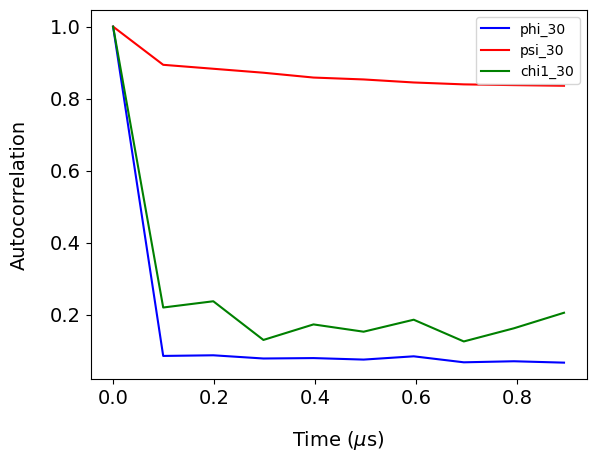

In [81]:
###### 2.) Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi30_acf=autocorr1(dihedral_dict['phi'][30],lags) #acf = autocorrelation fun
psi30_acf=autocorr1(dihedral_dict['psi'][30],lags)
chi30_acf=autocorr1(dihedral_dict['chi1'][30],lags)

plt.plot(time[lags],phi30_acf,color='b',label='phi_30')
plt.plot(time[lags],psi30_acf,color='r',label='psi_30')
plt.plot(time[lags],chi30_acf,color='g',label='chi1_30')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

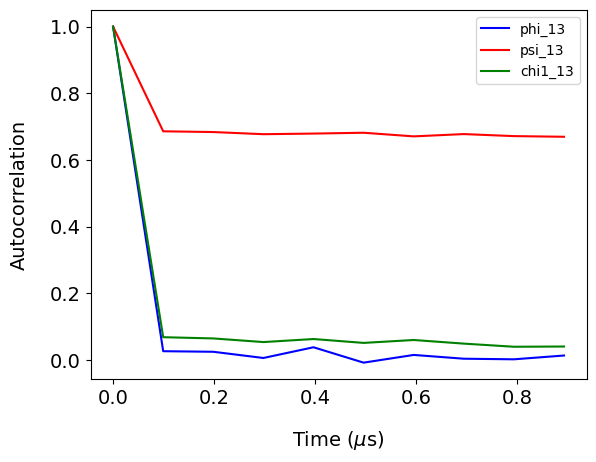

In [89]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi13_acf=autocorr1(dihedral_dict['phi'][13],lags) #acf = autocorrelation fun
psi13_acf=autocorr1(dihedral_dict['psi'][13],lags)
chi13_acf=autocorr1(dihedral_dict['chi1'][13],lags)

plt.plot(time[lags],phi13_acf,color='b',label='phi_13')
plt.plot(time[lags],psi13_acf,color='r',label='psi_13')
plt.plot(time[lags],chi13_acf,color='g',label='chi1_13')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

#structural snapshots that explain why certain correlation times are longer
![residues%20with%20long%20correlation%20times%289,13,30%20&33%29%20;%20residue%20with%20short%20correlation%20time%20(52).png](attachment:residues%20with%20long%20correlation%20times%289,13,30%20&33%29%20;%20residue%20with%20short%20correlation%20time%20(52).png)

Long correlation times greater than 0.2(threshold) were observed for residues 9, 13, 30 and 33. Resid 52 has a low correlation time less than 0.2 was included in this analysis as a comparison between the dynamic and undynamic regions of the protein. Red residues represent the minor state whilst blue residues represent the major state. Residues within the major state are observed to be clustered together and mostly pointed in the same direction across different frames. Meanwhile, residues in the minor state are observed to be in varying positions across different frames. Also the the loops, beta sheets and helices are observed to be in a more relaxed and open or turned in dfferent direction as observed for resids 9, 13, 30 and 33. Observations for secondary structure around Residue 52 shows a more compact or clustering of the loops together whether in the minor or major states. 
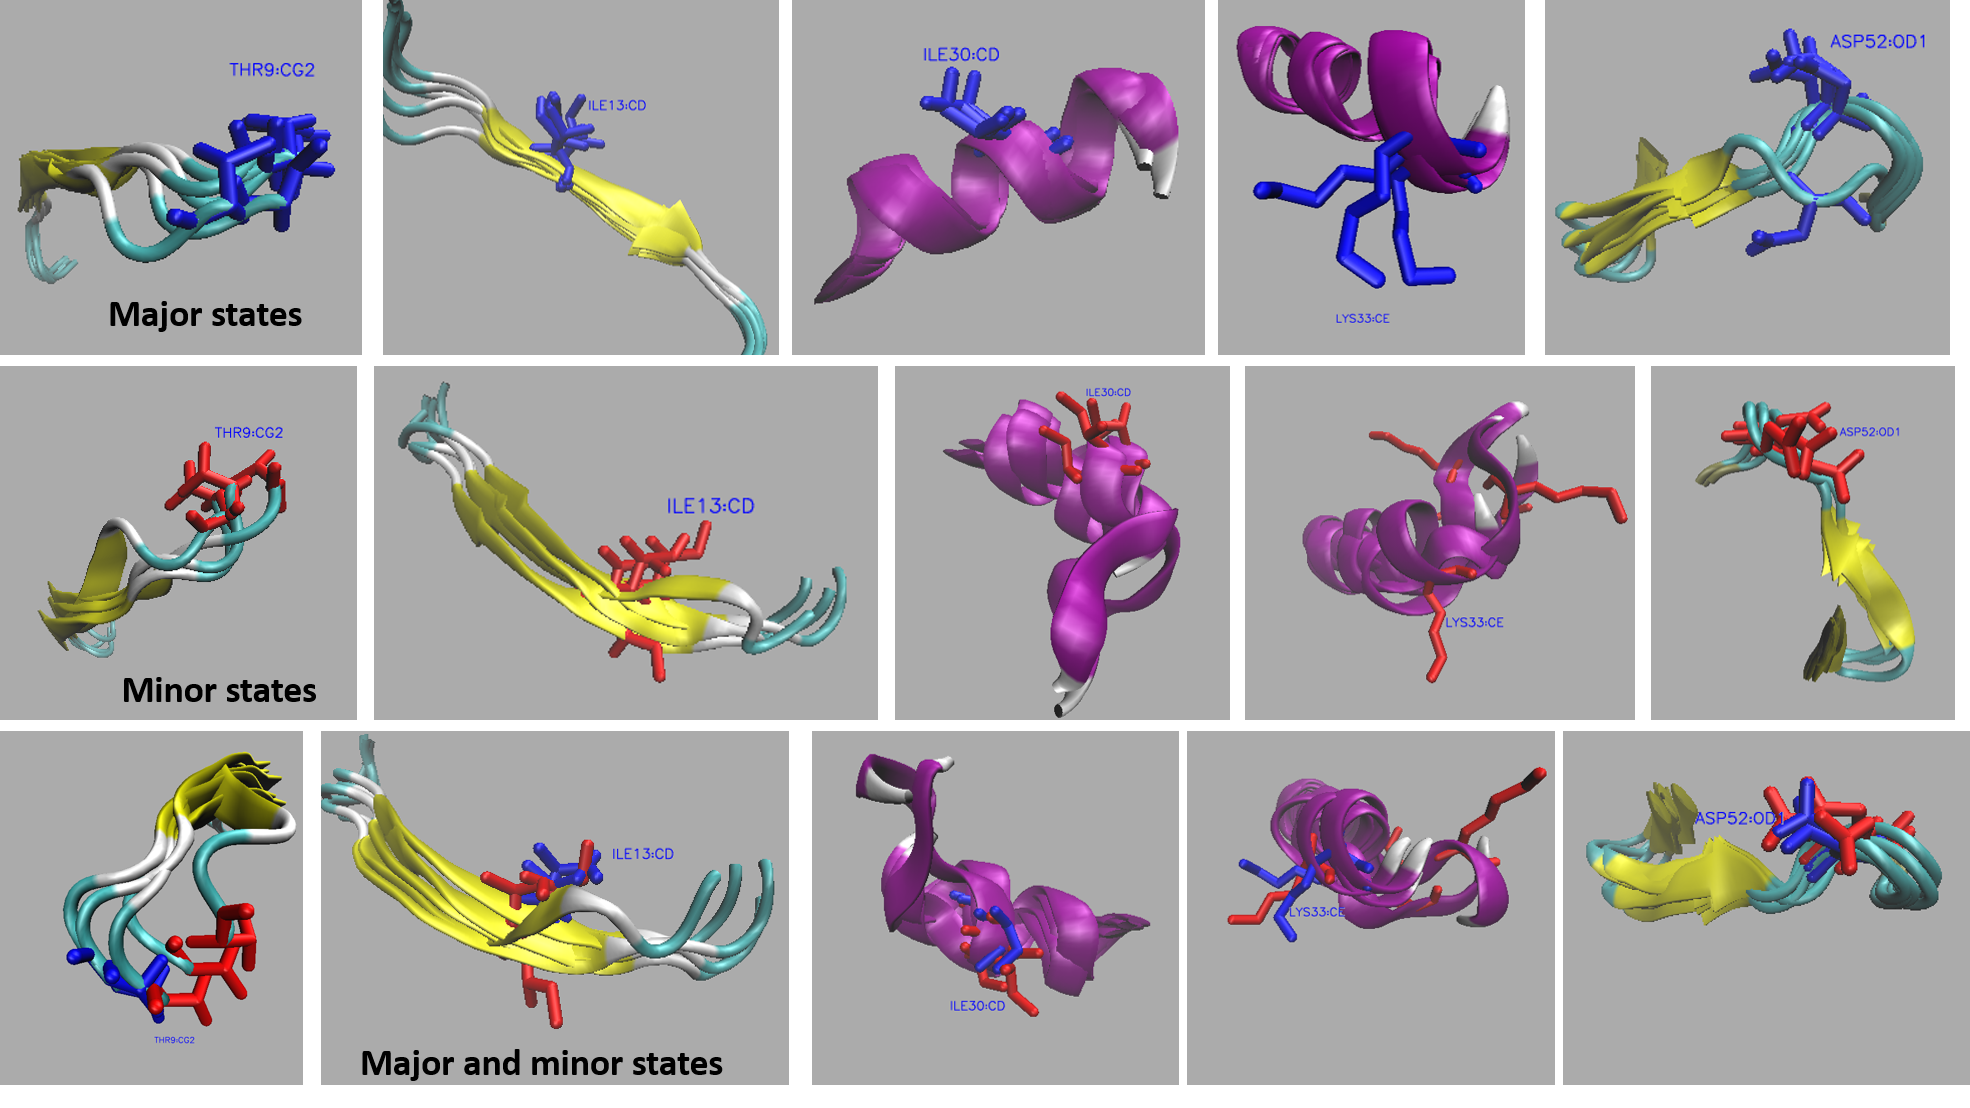

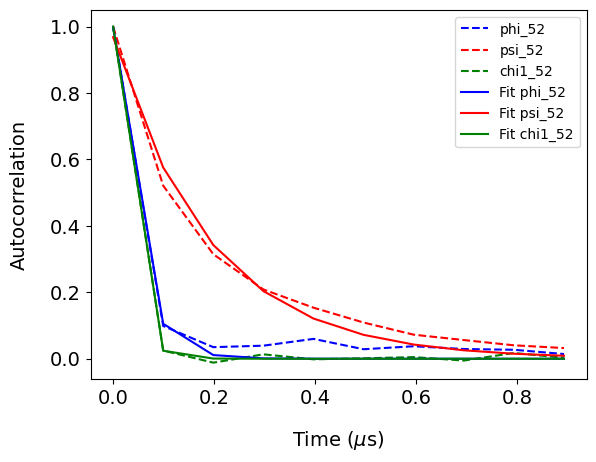

Correlation times:
phi_52: 0.044062011169429434
psi_52: 0.19069303988860706
chi1_52: 0.026623074621453833


In [50]:
#2a Can you calculate/ fit the correlation times
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential_decay(t, tau, A):
    """Exponential decay function"""
    return A * np.exp(-t / tau)

def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Define time in microseconds
time = np.linspace(0, 1000, trj.n_frames)

# Define the lags for autocorrelation analysis
lags = range(10)

# Calculate autocorrelation for specific dihedral angles
phi52_acf = autocorr1(dihedral_dict['phi'][52], lags)
psi52_acf = autocorr1(dihedral_dict['psi'][52], lags)
chi52_acf = autocorr1(dihedral_dict['chi1'][52], lags)

# Fit exponential decay curve to autocorrelation data
popt_phi52, pcov_phi52 = curve_fit(exponential_decay, time[lags], phi52_acf)
popt_psi52, pcov_psi52 = curve_fit(exponential_decay, time[lags], psi52_acf)
popt_chi52, pcov_chi52 = curve_fit(exponential_decay, time[lags], chi52_acf)

# Plot autocorrelation functions against lag time
plt.plot(time[lags], phi52_acf, 'b--', label='phi_52')
plt.plot(time[lags], psi52_acf, 'r--', label='psi_52')
plt.plot(time[lags], chi52_acf, 'g--', label='chi1_52')

# Plot fitted curves
plt.plot(time[lags], exponential_decay(time[lags], *popt_phi52), 'b-', label='Fit phi_52')
plt.plot(time[lags], exponential_decay(time[lags], *popt_psi52), 'r-', label='Fit psi_52')
plt.plot(time[lags], exponential_decay(time[lags], *popt_chi52), 'g-', label='Fit chi1_52')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

# Extract correlation times from fitted parameters
tau_phi52 = popt_phi52[0]
tau_psi52 = popt_psi52[0]
tau_chi52 = popt_chi52[0]

print("Correlation times:")
print("phi_52:", tau_phi52)
print("psi_52:", tau_psi52)
print("chi1_52:", tau_chi52)


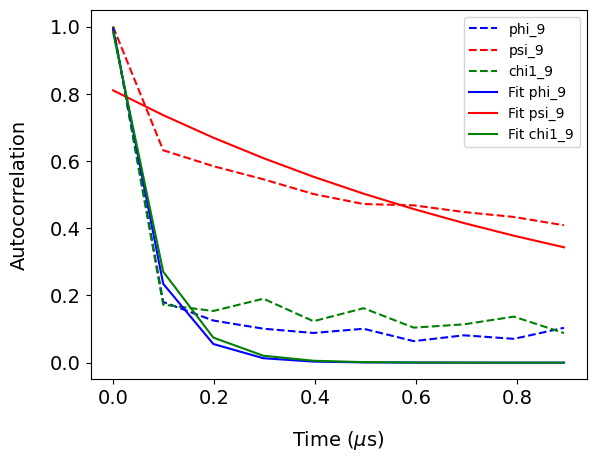

Correlation times:
phi_9: 0.06875876474462499
psi_9: 1.0390278786220244
chi1_9: 0.07686112072709399


In [87]:
# Calculate autocorrelation for specific dihedral angles
phi9_acf = autocorr1(dihedral_dict['phi'][9], lags)
psi9_acf = autocorr1(dihedral_dict['psi'][9], lags)
chi9_acf = autocorr1(dihedral_dict['chi1'][9], lags)

# Fit exponential decay curve to autocorrelation data
popt_phi9, pcov_phi9 = curve_fit(exponential_decay, time[lags], phi9_acf)
popt_psi9, pcov_psi9 = curve_fit(exponential_decay, time[lags], psi9_acf)
popt_chi9, pcov_chi9 = curve_fit(exponential_decay, time[lags], chi9_acf)

# Plot autocorrelation functions against lag time
plt.plot(time[lags], phi9_acf, 'b--', label='phi_9')
plt.plot(time[lags], psi9_acf, 'r--', label='psi_9')
plt.plot(time[lags], chi9_acf, 'g--', label='chi1_9')

# Plot fitted curves
plt.plot(time[lags], exponential_decay(time[lags], *popt_phi9), 'b-', label='Fit phi_9')
plt.plot(time[lags], exponential_decay(time[lags], *popt_psi9), 'r-', label='Fit psi_9')
plt.plot(time[lags], exponential_decay(time[lags], *popt_chi9), 'g-', label='Fit chi1_9')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

# Extract correlation times from fitted parameters
tau_phi9 = popt_phi9[0]
tau_psi9 = popt_psi9[0]
tau_chi9 = popt_chi9[0]

print("Correlation times:")
print("phi_9:", tau_phi9)
print("psi_9:", tau_psi9)
print("chi1_9:", tau_chi9)


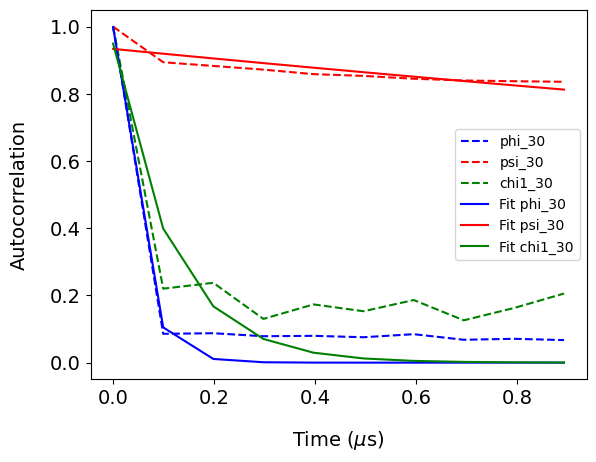

Correlation times:
phi_13: 0.04397802592186905
psi_13: 6.419381799865216
chi1_13: 0.11433559308061422


In [85]:
# Calculate autocorrelation for specific dihedral angles
phi30_acf = autocorr1(dihedral_dict['phi'][30], lags)
psi30_acf = autocorr1(dihedral_dict['psi'][30], lags)
chi30_acf = autocorr1(dihedral_dict['chi1'][30], lags)

# Fit exponential decay curve to autocorrelation data
popt_phi30, pcov_phi30 = curve_fit(exponential_decay, time[lags], phi30_acf)
popt_psi30, pcov_psi30 = curve_fit(exponential_decay, time[lags], psi30_acf)
popt_chi30, pcov_chi30 = curve_fit(exponential_decay, time[lags], chi30_acf)

# Plot autocorrelation functions against lag time
plt.plot(time[lags], phi30_acf, 'b--', label='phi_30')
plt.plot(time[lags], psi30_acf, 'r--', label='psi_30')
plt.plot(time[lags], chi30_acf, 'g--', label='chi1_30')

# Plot fitted curves
plt.plot(time[lags], exponential_decay(time[lags], *popt_phi30), 'b-', label='Fit phi_30')
plt.plot(time[lags], exponential_decay(time[lags], *popt_psi30), 'r-', label='Fit psi_30')
plt.plot(time[lags], exponential_decay(time[lags], *popt_chi30), 'g-', label='Fit chi1_30')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

# Extract correlation times from fitted parameters
tau_phi30 = popt_phi30[0]
tau_psi30 = popt_psi30[0]
tau_chi30 = popt_chi30[0]

print("Correlation times:")
print("phi_13:", tau_phi30)
print("psi_13:", tau_psi30)
print("chi1_13:", tau_chi30)


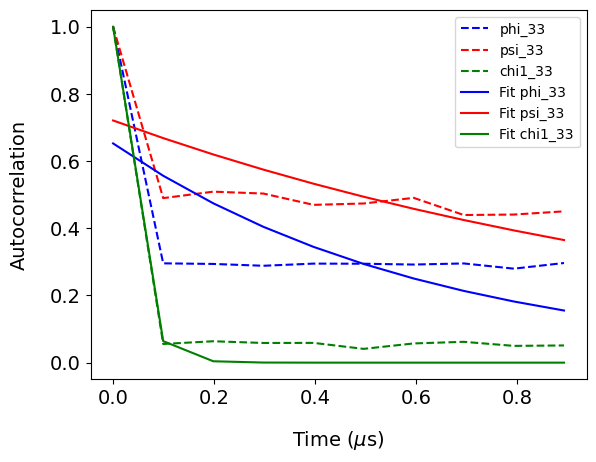

Correlation times:
phi_33: 0.6211428897323678
psi_33: 1.3106622367442136
chi1_33: 0.036071735210871606


In [86]:
# Calculate autocorrelation for specific dihedral angles
phi33_acf = autocorr1(dihedral_dict['phi'][33], lags)
psi33_acf = autocorr1(dihedral_dict['psi'][33], lags)
chi33_acf = autocorr1(dihedral_dict['chi1'][33], lags)

# Fit exponential decay curve to autocorrelation data
popt_phi33, pcov_phi33 = curve_fit(exponential_decay, time[lags], phi33_acf)
popt_psi33, pcov_psi33 = curve_fit(exponential_decay, time[lags], psi33_acf)
popt_chi33, pcov_chi33 = curve_fit(exponential_decay, time[lags], chi33_acf)

# Plot autocorrelation functions against lag time
plt.plot(time[lags], phi33_acf, 'b--', label='phi_33')
plt.plot(time[lags], psi33_acf, 'r--', label='psi_33')
plt.plot(time[lags], chi33_acf, 'g--', label='chi1_33')

# Plot fitted curves
plt.plot(time[lags], exponential_decay(time[lags], *popt_phi33), 'b-', label='Fit phi_33')
plt.plot(time[lags], exponential_decay(time[lags], *popt_psi33), 'r-', label='Fit psi_33')
plt.plot(time[lags], exponential_decay(time[lags], *popt_chi33), 'g-', label='Fit chi1_33')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

# Extract correlation times from fitted parameters
tau_phi33 = popt_phi33[0]
tau_psi33 = popt_psi33[0]
tau_chi33 = popt_chi33[0]

print("Correlation times:")
print("phi_33:", tau_phi33)
print("psi_33:", tau_psi33)
print("chi1_33:", tau_chi33)


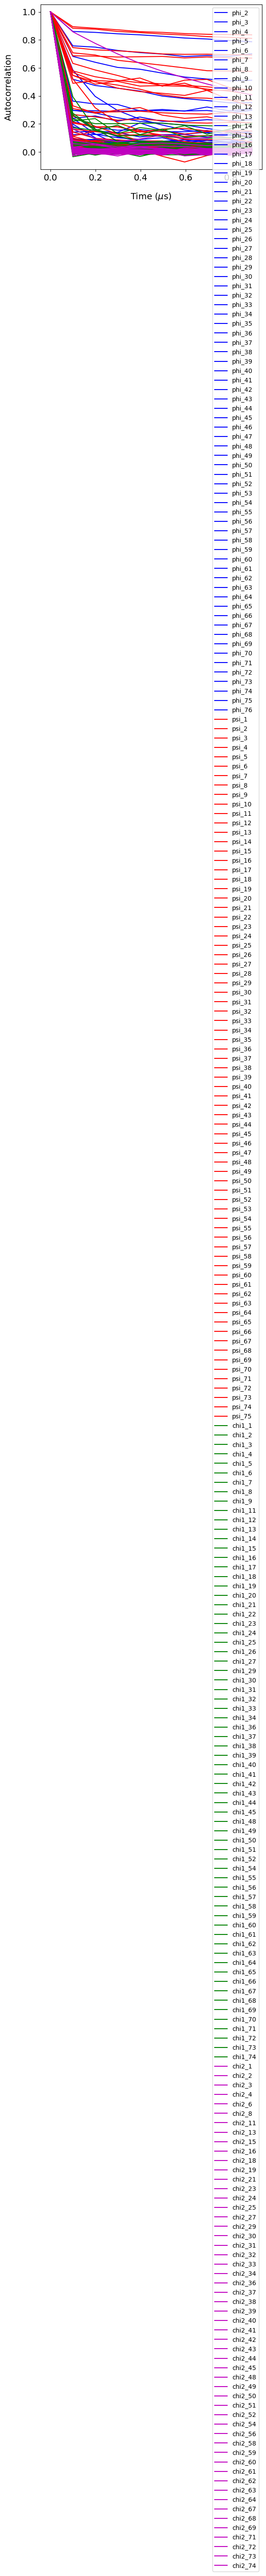

In [51]:
#2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold?

import numpy as np
import matplotlib.pyplot as plt

# Define your threshold value here (in microseconds)
threshold = 0.2

# Dictionary to store correlation times for each dihedral
correlation_times = {}
lags = range(10)

# Loop over all phi/psi/chi1/chi2 residues
for residue_type in ['phi', 'psi', 'chi1', 'chi2']:
    for residue_number in dihedral_dict[residue_type].keys():  
        # Calculate autocorrelation for each dihedral angle
        dihedral_acf = autocorr1(dihedral_dict[residue_type][residue_number], lags)
        # Calculate correlation time (e.g., time for autocorrelation to decay to 0.1)
        decay_indices = np.where(dihedral_acf > 0.1)[0]
        if len(decay_indices) > 0:
            correlation_time = decay_indices[0] * (time[1] - time[0])
            correlation_times[f"{residue_type}_{residue_number}"] = correlation_time

            if correlation_time > threshold:
                print(f"Residue {residue_type}_{residue_number} has correlation time longer than {threshold} microseconds.")
        else:
            print(f"No correlation time below 0.1 found for residue {residue_type}_{residue_number}.")
            
# Plotting the autocorrelation functions (optional)
for residue_type, color in zip(['phi', 'psi', 'chi1', 'chi2'], ['b', 'r', 'g', 'm']):
    for residue_number in dihedral_dict[residue_type].keys():  
        dihedral_acf = autocorr1(dihedral_dict[residue_type][residue_number], lags)
        plt.plot(time[lags], dihedral_acf, color=color, label=f"{residue_type}_{residue_number}")

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()


In [52]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define autocorrelation function
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Generate time values
time = np.linspace(0, 1000, trj.n_frames)

# Define lags for autocorrelation analysis
lags = range(10)

auto_corr_time_dict = {}
# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_dict[angle].get(residue, np.zeros(trj.n_frames)), lags)
    
        # Define a linear function for regression
        def linear_func(t, m, c):
            return m * t + c

        # Perform linear regression for each autocorrelation curve using the first two lag values
        linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])

        # Print the slopes
        print(f"Autocorrelation time for {angle} at residues {residue}: {-1/linfit_angle[0]}")
        if angle not in auto_corr_time_dict.keys(): \
            auto_corr_time_dict[angle]={}
        auto_corr_time_dict[angle][residue] = - 1/linfit_angle[0]
        

C:\Users\Keren\AppData\Local\Temp\ipykernel_18704\3873399171.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])


Autocorrelation time for phi at residues 2: 0.10237117410570144
Autocorrelation time for phi at residues 3: 0.10112463404678891
Autocorrelation time for phi at residues 4: 0.09890450433635352
Autocorrelation time for phi at residues 5: 0.10009596076960042
Autocorrelation time for phi at residues 6: 0.10822796315438987
Autocorrelation time for phi at residues 7: 0.11539688425665125
Autocorrelation time for phi at residues 8: 0.14095443176638317
Autocorrelation time for phi at residues 9: 0.12097230138240574
Autocorrelation time for phi at residues 10: 0.3116724714320144
Autocorrelation time for phi at residues 11: 0.10359177451685012
Autocorrelation time for phi at residues 12: 0.10678801231260708
Autocorrelation time for phi at residues 13: 0.10182745114620508
Autocorrelation time for phi at residues 14: 0.10704505966756934
Autocorrelation time for phi at residues 15: 0.10035688518563221
Autocorrelation time for phi at residues 16: 0.10011332592511804
Autocorrelation time for phi at re

Autocorrelation time for chi1 at residues 13: 0.10642079597960226
Autocorrelation time for chi1 at residues 14: 0.10049991108879056
Autocorrelation time for chi1 at residues 15: 0.10031811531699668
Autocorrelation time for chi1 at residues 16: 0.09966699268539272
Autocorrelation time for chi1 at residues 17: 0.09997049413347271
Autocorrelation time for chi1 at residues 18: 0.0980562248614231
Autocorrelation time for chi1 at residues 19: 0.10116068222600554
Autocorrelation time for chi1 at residues 20: 0.09764066039467485
Autocorrelation time for chi1 at residues 21: 0.10007100075364336
Autocorrelation time for chi1 at residues 22: 0.11842541453751583
Autocorrelation time for chi1 at residues 23: 0.1369373294165258
Autocorrelation time for chi1 at residues 24: 0.0978965594726615
Autocorrelation time for chi1 at residues 25: 0.09832557550528231
Autocorrelation time for chi1 at residues 26: 0.09955349626689568
Autocorrelation time for chi1 at residues 27: 0.09691013918201809
Autocorrelati

In [53]:
dihedral_dict['phi'].keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76])

In [54]:
dihedral_dict['psi'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])

In [55]:
dihedral_dict['chi1'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])

In [56]:
dihedral_dict['chi2'].keys()

dict_keys([1, 2, 3, 4, 6, 8, 11, 13, 15, 16, 18, 19, 21, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 54, 56, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 71, 72, 73, 74])

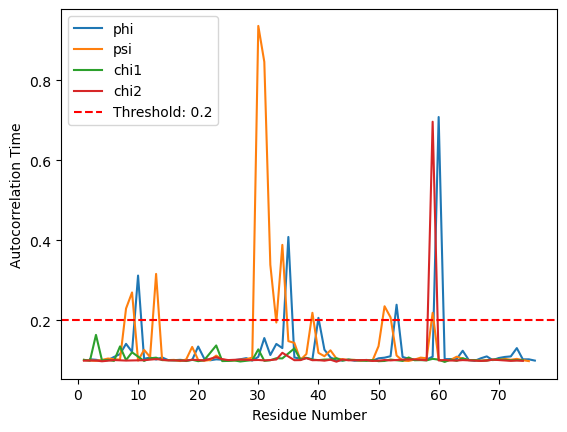

In [57]:
import matplotlib.pyplot as plt

#define threshold
threshold = 0.2

for angle in auto_corr_time_dict.keys():
    a_corr_arr = []
    residues = list(auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)

plt.legend()
plt.xlabel('Residue Number')  # Label for the x-axis
plt.ylabel('Autocorrelation Time')  # Label for the y-axis
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()


C:\Users\Keren\AppData\Local\Temp\ipykernel_18704\3639382679.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_, pcov_ = curve_fit(linear_regression, time[lags][:2], np.log(dihedral_acf[:2]))


Residue phi_10 has correlation time longer than 0.2 microseconds: 0.2589485499632953 microseconds.
Residue phi_35 has correlation time longer than 0.2 microseconds: 0.3562822184987212 microseconds.
Residue phi_60 has correlation time longer than 0.2 microseconds: 0.6571723679798622 microseconds.
Residue psi_9 has correlation time longer than 0.2 microseconds: 0.21613904002102496 microseconds.
Residue psi_13 has correlation time longer than 0.2 microseconds: 0.26310311877870596 microseconds.
Residue psi_30 has correlation time longer than 0.2 microseconds: 0.8851905639695372 microseconds.
Residue psi_31 has correlation time longer than 0.2 microseconds: 0.7952107180596693 microseconds.
Residue psi_32 has correlation time longer than 0.2 microseconds: 0.2862341824382535 microseconds.
Residue psi_34 has correlation time longer than 0.2 microseconds: 0.3363984279075713 microseconds.
Residue chi2_59 has correlation time longer than 0.2 microseconds: 0.6453330892973819 microseconds.


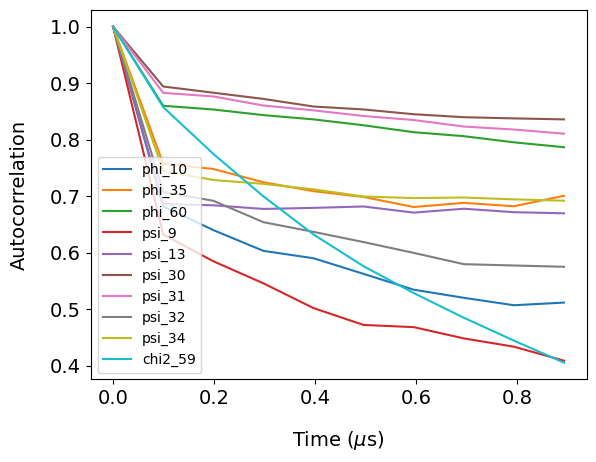

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define linear regression function
def linear_regression(x, m, c):
    return m * x + c

# Define your threshold value here (in microseconds)
threshold = 0.2

# List to store the residues with autocorrelation times greater than the threshold
residues_above_threshold = []

# Loop over all phi/psi/chi1/chi2 residues
for residue_type in ['phi', 'psi', 'chi1', 'chi2']:
    for residue_number, dihedral_data in dihedral_dict[residue_type].items():  
        # Calculate autocorrelation for each dihedral angle
        dihedral_acf = autocorr1(dihedral_data, lags)
        # Calculate correlation time (e.g., time for autocorrelation to decay to 0.1)
        correlation_time = 0
        if dihedral_acf[1] > 0: 
            popt_, pcov_ = curve_fit(linear_regression, time[lags][:2], np.log(dihedral_acf[:2]))
            correlation_time = -1/popt_[0]
            
            if correlation_time > threshold:
                residues_above_threshold.append((residue_type, residue_number, correlation_time))
                print(f"Residue {residue_type}_{residue_number} has correlation time longer than {threshold} microseconds: {correlation_time} microseconds.")

# Plotting only residues with correlation time greater than the threshold
for residue_type, residue_number, correlation_time in residues_above_threshold:
    dihedral_acf = autocorr1(dihedral_dict[residue_type][residue_number], lags)
    plt.plot(time[lags], dihedral_acf, label=f"{residue_type}_{residue_number}")

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()


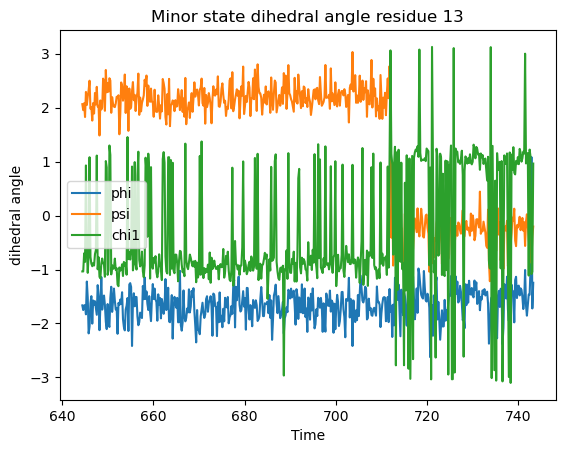

In [35]:
#Q3-Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles? Are there torsion angles with large differences in their correlation times between states? Can you provide trajectory snapshots that explain why?

residue= 13
plt.plot(time[6500:7500:2], dihedral_dict['phi'][13][6500:7500:2], label='phi')
plt.plot(time[6500:7500:2], dihedral_dict['psi'][13][6500:7500:2], label='psi')
plt.plot(time[6500:7500:2], dihedral_dict['chi1'][13][6500:7500:2], label='chi1')

plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('Minor state dihedral angle residue 13')
plt.legend()
plt.show()

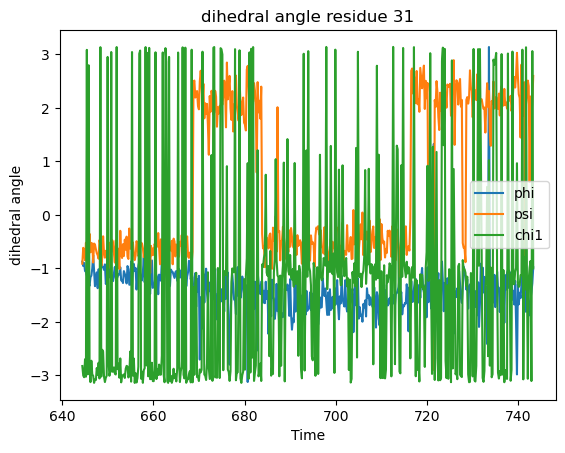

In [61]:
residue= 31
plt.plot(time[6500:7500:2], dihedral_dict['phi'][31][6500:7500:2], label='phi')
plt.plot(time[6500:7500:2], dihedral_dict['psi'][31][6500:7500:2], label='psi')
plt.plot(time[6500:7500:2], dihedral_dict['chi1'][31][6500:7500:2], label='chi1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('dihedral angle residue 31')
plt.legend()
plt.show()

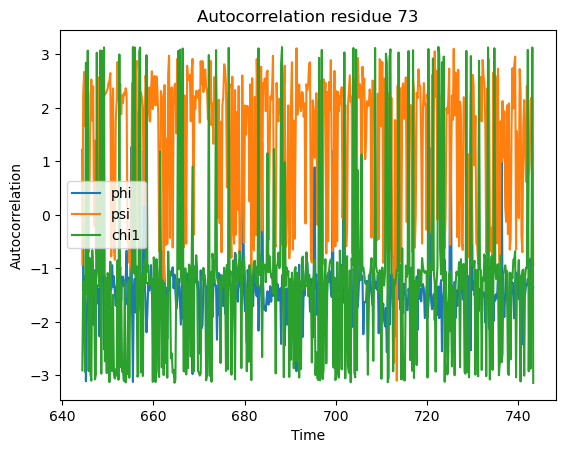

In [62]:
residue= 73
plt.plot(time[6500:7500:2], dihedral_dict['phi'][73][6500:7500:2], label='phi')
plt.plot(time[6500:7500:2], dihedral_dict['psi'][73][6500:7500:2], label='psi')
plt.plot(time[6500:7500:2], dihedral_dict['chi1'][73][6500:7500:2], label='chi1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation residue 73')
plt.legend()
plt.show()

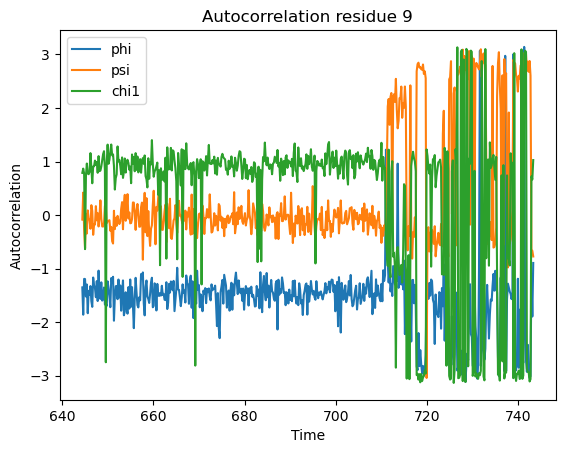

In [63]:
residue= 9
plt.plot(time[6500:7500:2], dihedral_dict['phi'][9][6500:7500:2], label='phi')
plt.plot(time[6500:7500:2], dihedral_dict['psi'][9][6500:7500:2], label='psi')
plt.plot(time[6500:7500:2], dihedral_dict['chi1'][9][6500:7500:2], label='chi1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation residue 9')
plt.legend()
plt.show()

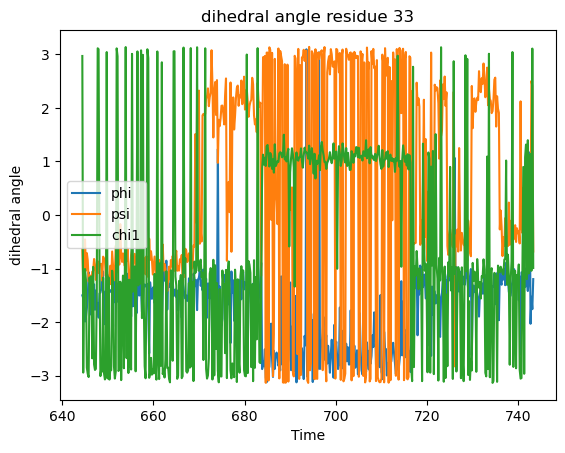

In [32]:
#Q3 - Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles? Are there torsion angles with large differences in their correlation times between states? Can you provide trajectory snapshots that explain why?
# identified regions are in q2
#minor state
residue= 33
plt.plot(time[6500:7500:2], dihedral_dict['phi'][33][6500:7500:2], label='phi')
plt.plot(time[6500:7500:2], dihedral_dict['psi'][33][6500:7500:2], label='psi')
plt.plot(time[6500:7500:2], dihedral_dict['chi1'][33][6500:7500:2], label='chi1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('dihedral angle residue 33')
plt.legend()
plt.show()

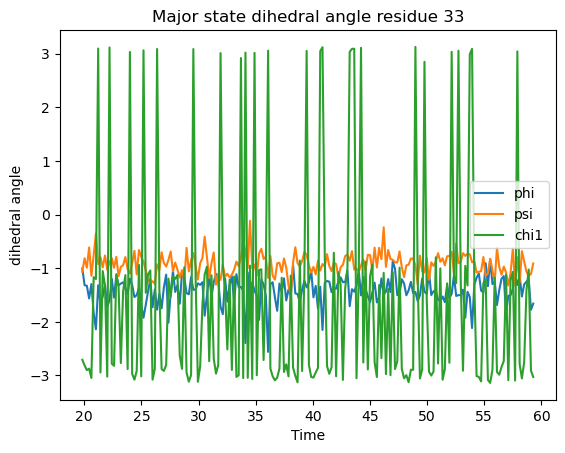

In [33]:
#Major state
residue= 33
plt.plot(time[200:600:2], dihedral_dict['phi'][33][200:600:2], label='phi')
plt.plot(time[200:600:2], dihedral_dict['psi'][33][200:600:2], label='psi')
plt.plot(time[200:600:2], dihedral_dict['chi1'][33][200:600:2], label='chi1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('Major state dihedral angle residue 33')
plt.legend()
plt.show()

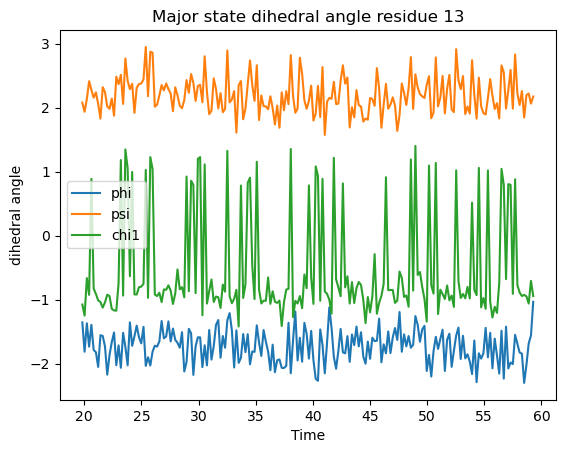

In [34]:
#Major state
residue= 13
plt.plot(time[200:600:2], dihedral_dict['phi'][13][200:600:2], label='phi')
plt.plot(time[200:600:2], dihedral_dict['psi'][13][200:600:2], label='psi')
plt.plot(time[200:600:2], dihedral_dict['chi1'][13][200:600:2], label='chi1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('Major state dihedral angle residue 13')
plt.legend()
plt.show()

#Q3 - Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles? Are there torsion angles with large differences in their correlation times between states? Can you provide trajectory snapshots that explain why?
Residues of interest is resid 13 and 33
Residue 13 and 33 shows large changes in the dihedral angles as observed in the plots above. Also the calculated correlation times shown in Q2, shows large correlation time difference. From the images above, the residue 13 is in the minor state is oberved to be in the opposite direction to the major state whilst that of 33 is all over the place and this shows how dynamic the the minor states are, which can be attributed to high degrees of freedom at those sites


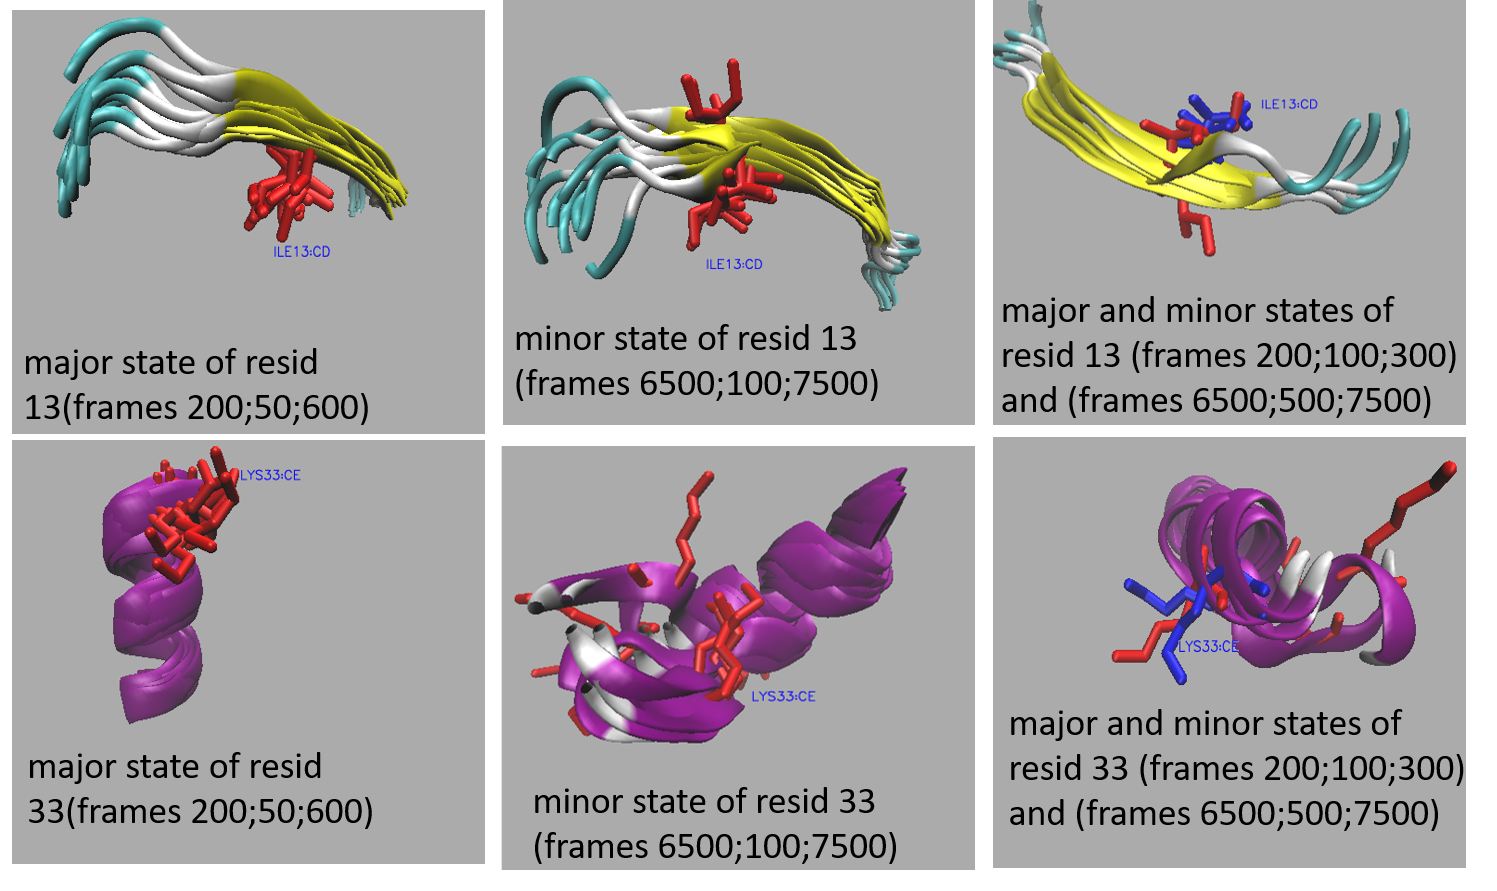

In [ ]:
# 4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier.
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(phi,psi):
    cmean1=circular_mean(phi)
    cmean2=circular_mean(psi)
    numerator=(np.sum(np.sin(phi-cmean1)*np.sin(psi-cmean2)))
    denom=((np.sum(np.sin(phi-cmean1)**2)*np.sum(np.sin(psi-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [65]:
# Make correlation contact map
correlation_maps = []
for i in range(2, 76):
    cor_map = []
    for j in range(2, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_cor_map)

(74, 74)

In [66]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:76]
#Lets Zero Out some of the Labels 
n=4
for i in range (0,75): 
  if (i % n !=0):
   seq_trunc[i]=''
print(seq_trunc)
print(sequence)

[GLN2, '', '', '', LYS6, '', '', '', GLY10, '', '', '', THR14, '', '', '', GLU18, '', '', '', THR22, '', '', '', VAL26, '', '', '', ILE30, '', '', '', GLU34, '', '', '', PRO38, '', '', '', ARG42, '', '', '', ALA46, '', '', '', LEU50, '', '', '', ARG54, '', '', '', ASP58, '', '', '', GLN62, '', '', '', THR66, '', '', '', VAL70, '', '', '', ARG74, '', '']
[MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]


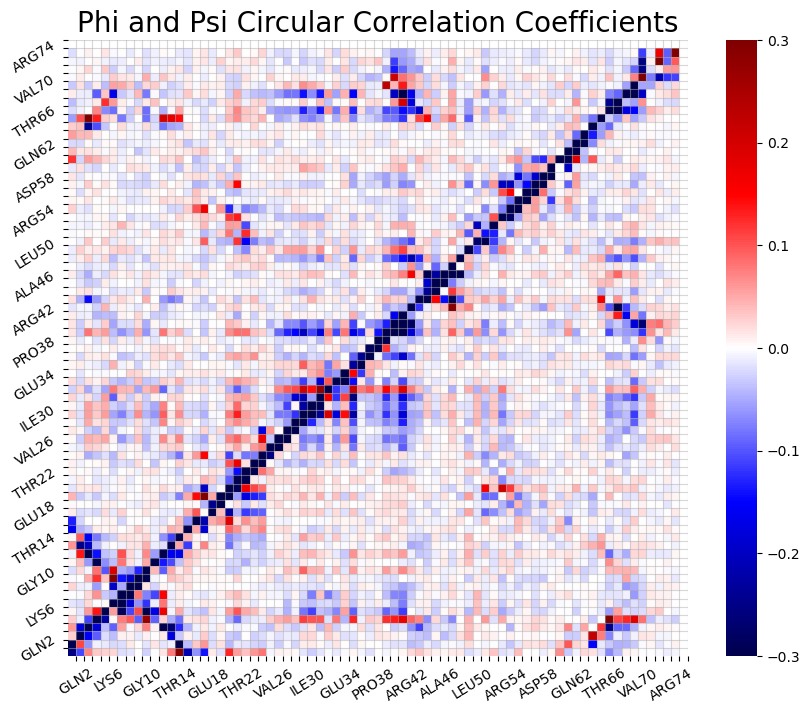

In [67]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
plt.figure(figsize=(10, 8)) 
ax = sns.heatmap(final_cor_map, vmin=-0.3, vmax=0.3,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(1,76))
ax.set_yticks(range(1,76))
ax.set_xticklabels(seq_trunc,rotation=32)
ax.set_yticklabels(seq_trunc,rotation=32)
ax.set_title('Phi and Psi Circular Correlation Coefficients', fontsize=20)
plt.show()

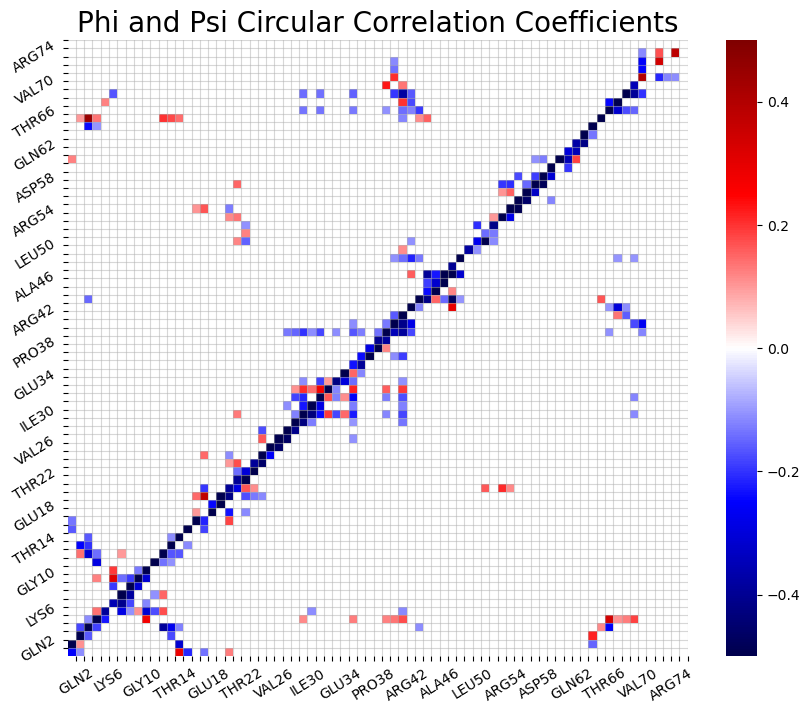

In [68]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
plt.figure(figsize=(10, 8))
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(1,76))
ax.set_yticks(range(1,76))
ax.set_xticklabels(seq_trunc,rotation=32)
ax.set_yticklabels(seq_trunc,rotation=32)
ax.set_title('Phi and Psi Circular Correlation Coefficients', fontsize=20)
plt.show()

In [69]:
#Q5Make a 2D map showing the populations of hydrogen bonds between different residues.

hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
THR22-N -- ASN25-OD1
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N -- LYS27-O
ASP32-N

In [70]:
np.shape(hbonds)

(114, 3)

In [71]:

for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   1 285] MET1-N VAL17-O
[  0   2 285] MET1-N VAL17-O
[  0   3 285] MET1-N VAL17-O
[ 36  37 254] ILE3-N LEU15-O
[  55   56 1044] PHE4-N SER65-O
[ 75  76 221] VAL5-N ILE13-O
[  91   92 1077] LYS6-N LEU67-O
[113 114 188] THR7-N LYS11-O
[127 128 119] LEU8-N THR7-OG1
[ 127  128 1113] LEU8-N LEU69-O
[146 147 119] THR9-N THR7-OG1
[160 161 126] GLY10-N THR7-O
[167 168 119] LYS11-N THR7-OG1
[183 184 551] LYS11-NZ GLU34-OE1
[183 184 552] LYS11-NZ GLU34-OE2
[183 185 551] LYS11-NZ GLU34-OE1
[183 185 552] LYS11-NZ GLU34-OE2
[183 186 551] LYS11-NZ GLU34-OE1
[183 186 552] LYS11-NZ GLU34-OE2
[203 204  90] ILE13-N VAL5-O
[236 237  54] LEU15-N ILE3-O
[270 271  18] VAL17-N MET1-O
[286 287 334] GLU18-N ASP21-OD1
[286 287 335] GLU18-N ASP21-OD2
[326 327 300] ASP21-N GLU18-O
[338 339 394] THR22-N ASN25-OD1
[352 353 869] ILE23-N ARG54-O
[371 372 838] GLU24-N ASP52-O
[386 387 344] ASN25-N THR22-OG1
[386 387 351] ASN25-N THR22-O
[395 396 344] ASN25-ND2 THR22-OG1
[395 397 344] ASN25-ND2 THR22-OG1
[400 401 

In [77]:

# Assuming trj is properly defined before this point
# trj = ...

# Get the number of residues
num_residues = trj.n_residues

# Get the number of frames
frames = range(trj.n_frames)

# Initialize a square matrix to store the count of hydrogen bonds for each residue
hbond_population_matrix = np.zeros((num_residues, num_residues), dtype=int)

# Iterate over each frame
for frame in frames:
    # Calculate the hydrogen bonds for the current frame
    hbonds = md.baker_hubbard(trj[frame], periodic=False)
    
    # Iterate over each hydrogen bond in the current frame
    for hbond in hbonds:
        # Get the donor and acceptor atoms
        donor_index = hbond[0]
        acceptor_index = hbond[2]
        
        # Initialize variables to store donor and acceptor residues
        donor_residue = None
        acceptor_residue = None
        
        # Iterate over each residue to find the donor and acceptor residues
        for residue in trj.topology.residues:
            # Check if the donor atom belongs to this residue
            if donor_index in [atom.index for atom in residue.atoms]:
                donor_residue = residue.index
                
            # Check if the acceptor atom belongs to this residue
            if acceptor_index in [atom.index for atom in residue.atoms]:
                acceptor_residue = residue.index

        # Increment the count in the matrix if both donor and acceptor residues are found
        if donor_residue is not None and acceptor_residue is not None:
            hbond_population_matrix[donor_residue, acceptor_residue] += 1
            hbond_population_matrix[acceptor_residue, donor_residue] += 1

# Print the hydrogen bond matrix
print(hbond_population_matrix)

print(donor_index)
print(acceptor_index)
print(donor_residue)
print(acceptor_residue)
print(frames)

[[   2    1    0 ...    0    0    0]
 [   1  140  216 ...    0    0    0]
 [   0  216    8 ...    0    0    0]
 ...
 [   0    0    0 ...   50   72 6181]
 [   0    0    0 ...   72    0    5]
 [   0    0    0 ... 6181    5   60]]
1041
996
64
61
range(0, 10088)


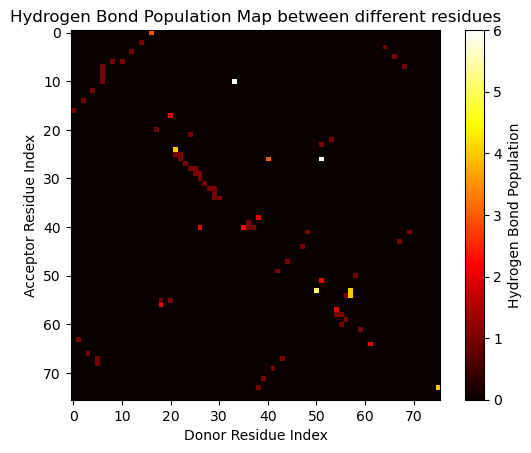

In [72]:
def calculate_hbond_population(trj):
    hbond_populations = np.zeros((trj.topology.n_residues, trj.topology.n_residues), dtype=int)
    for hbond in md.baker_hubbard(trj, periodic=False):
        donor_residue = trj.topology.atom(hbond[0]).residue.index
        acceptor_residue = trj.topology.atom(hbond[2]).residue.index
        hbond_populations[donor_residue, acceptor_residue] += 1
    return hbond_populations

def plot_hbond_map(hbond_populations):
    plt.imshow(hbond_populations, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Hydrogen Bond Population')
    plt.xlabel('Donor Residue Index')
    plt.ylabel('Acceptor Residue Index')
    plt.title('Hydrogen Bond Population Map between different residues')
    plt.show()

# Calculate hydrogen bond populations
hbond_populations = calculate_hbond_population(trj)

# Plot the hydrogen bond map
plot_hbond_map(hbond_populations)

In [73]:
print(hbond_populations)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 4]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


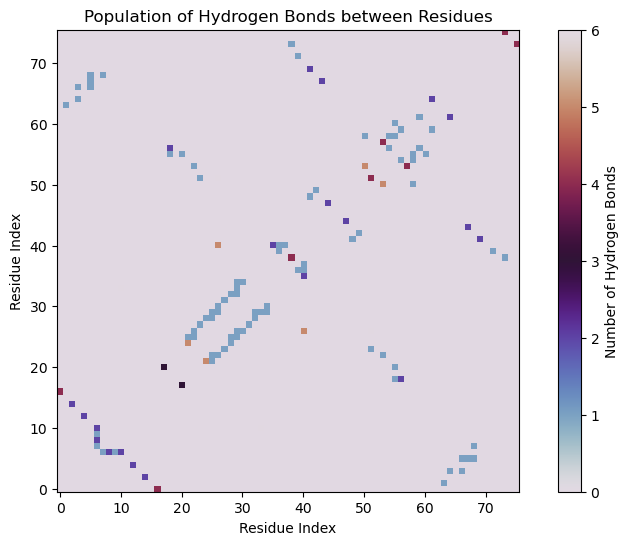

In [74]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

# Calculate hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)

# Get the maximum residue index
max_residue_index = max(trj.topology.residue(i).index for i in range(trj.n_residues)) + 1

# Initialize a matrix to store the count of hydrogen bonds for each residue
residue_hbond_count = np.zeros((max_residue_index, max_residue_index))

# Loop through each hydrogen bond
for hbond in hbonds:
    # Get the indices of the atoms involved in the hydrogen bond
    donor_index = hbond[0]
    acceptor_index = hbond[2]
    
    # Get the residue indices of the donor and acceptor atoms
    donor_residue_index = trj.topology.atom(donor_index).residue.index
    acceptor_residue_index = trj.topology.atom(acceptor_index).residue.index
    
    # Increment the count for the donor and acceptor residues
    residue_hbond_count[donor_residue_index, acceptor_residue_index] += 1
    residue_hbond_count[acceptor_residue_index, donor_residue_index] += 1

# Plotting 2D colormap
plt.figure(figsize=(10, 6))
plt.imshow(residue_hbond_count, cmap='twilight', origin='lower')
plt.colorbar(label='Number of Hydrogen Bonds')
plt.xlabel('Residue Index')
plt.ylabel('Residue Index')
plt.title('Population of Hydrogen Bonds between Residues')
plt.grid(False)
plt.show()


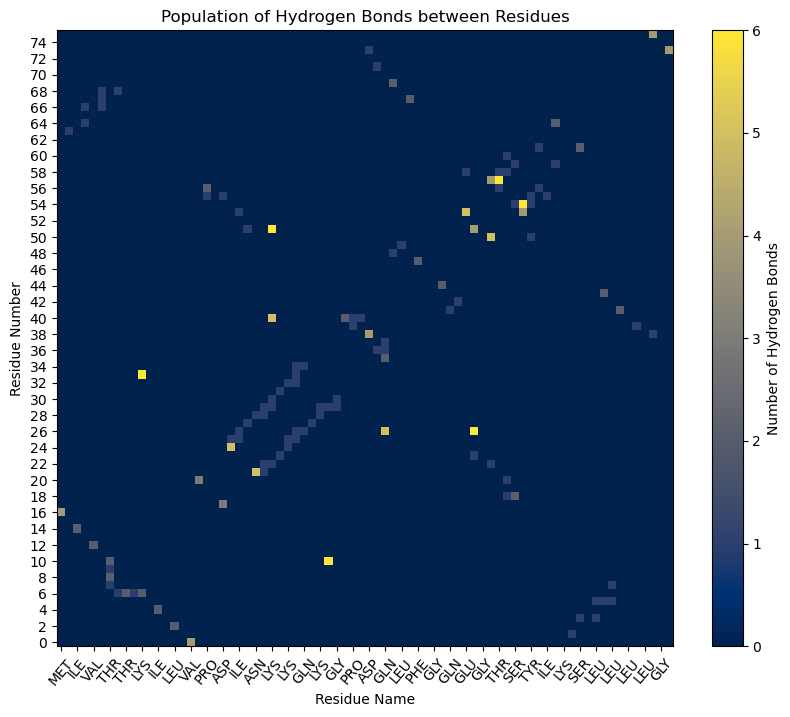

In [75]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

# Calculate hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)

# Get the maximum residue index
max_residue_index = max(trj.topology.residue(i).index for i in range(trj.n_residues)) + 1

# Initialize a matrix to store the count of hydrogen bonds for each residue
residue_hbond_count = np.zeros((max_residue_index, max_residue_index))

# Loop through each hydrogen bond
for hbond in hbonds:
    # Get the indices of the atoms involved in the hydrogen bond
    donor_index = hbond[0]
    acceptor_index = hbond[2]
    
    # Get the residue indices of the donor and acceptor atoms
    donor_residue_index = trj.topology.atom(donor_index).residue.index
    acceptor_residue_index = trj.topology.atom(acceptor_index).residue.index
    
    # Increment the count for the donor and acceptor residues
    residue_hbond_count[donor_residue_index, acceptor_residue_index] += 1
    residue_hbond_count[acceptor_residue_index, donor_residue_index] += 1

# Plotting 2D colormap
plt.figure(figsize=(10, 8))
plt.imshow(residue_hbond_count, cmap='cividis', origin='lower')
plt.colorbar(label='Number of Hydrogen Bonds')

# Get the residue names and numbers
residue_names = [residue.name for residue in trj.topology.residues]
residue_numbers = [residue.index for residue in trj.topology.residues]

# Show every 2th residue name and number
plt.xticks(range(0, max_residue_index, 2), [residue_names[i] for i in range(0, max_residue_index, 2)], rotation=50)
plt.yticks(range(0, max_residue_index, 2), [residue_numbers[i] for i in range(0, max_residue_index, 2)])

plt.xlabel('Residue Name')
plt.ylabel('Residue Number')
plt.title('Population of Hydrogen Bonds between Residues')
plt.grid(False)
plt.show()


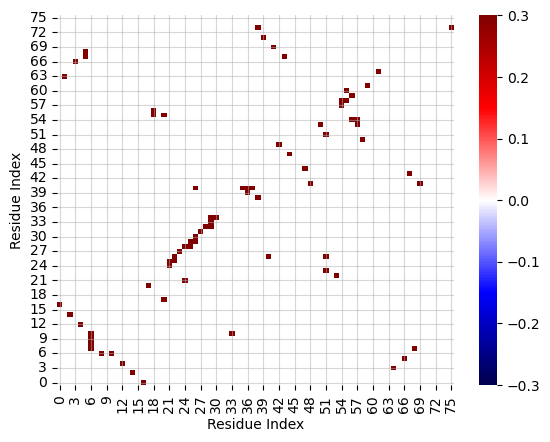

In [76]:
import seaborn as sns
import numpy as np

def plot_hbond_map(hbond_populations):
    mask = np.zeros_like(hbond_populations)
    zeros = np.where((hbond_populations < 0.10) & (hbond_populations > -0.10))
    mask[zeros] = True
    
    ax = sns.heatmap(hbond_populations, mask=mask, vmin=-0.3, vmax=0.3, cmap='seismic')
    
    ax.invert_yaxis()
    ax.grid(which='both', alpha=0.5)
    ax.set_xlabel('Residue Index')
    ax.set_ylabel('Residue Index')
    plt.show()

# Example usage
# hbond_populations should contain the population of hydrogen bonds for each residue
# Make sure hbond_populations is a numpy array and contains the correct data
plot_hbond_map(hbond_populations)

